<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
# <font color='blue'>Data Science Academy</font>
## <font color='blue'>Deep Learning Para Aplicações de Inteligência Artificial com Python e C++</font>
## <font color='blue'>Projeto 6</font>
### <font color='blue'>Temporal Fusion Transformers Para Prever o Retorno de Investimentos</font>

## Instalando e Carregando os Pacotes

In [1]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# !pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [2]:
%env TF_CPP_MIN_LOG_LEVEL=3

env: TF_CPP_MIN_LOG_LEVEL=3


Obs: Os pacotes abaixo estão aqui apenas para referência. Todas as versões e dependências estão no arquivo requirements.txt e o procedimento de instalação no arquivo LEIAME.txt.

In [3]:
# https://www.tensorflow.org/
#!pip install -q tensorflow

In [4]:
# https://pypi.org/project/yfinance/
#!pip install -q yfinance

In [5]:
# https://pypi.org/project/ta/
#!pip install -q ta

In [6]:
# Imports
import ta
import sklearn
import pandas as pd
import numpy as np
import tensorflow
import yfinance as yf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

In [7]:
%reload_ext watermark
%watermark -a "Data Science Academy"

Author: Data Science Academy



## Extração dos Dados Direto da Fonte

https://finance.yahoo.com/

### Função usada para a versão anterior do yfinance
def dsa_extrai_dados(ticker):
    
    # Busca todos os dados a partir de 01/01/2000 até 31/12/2023
    dados = yf.download(ticker, start = "2000-01-01", end = "2023-12-31")
    
    # Colunas do dataframe
    dados.columns = ["open", "high", "low", "close", "adj close", "volume"]
    
    # Data como índice
    dados.index.name = "date"
    
    return dados

Obs: Versões de pacotes mudam o tempo todo. SEMPRE visite a documentação dos pacotes para verificar as mudanças e ajustar o código conforme necessário!!!

In [8]:
# Função usada para a versão mais recente do yfinance
def dsa_extrai_dados(ticker):
    
    # Força que venha 'Adj Close' definindo auto_adjust=False
    dados = yf.download(ticker, start = "2000-01-01", end = "2023-12-31", auto_adjust = False)

    # Mapeamento dos nomes originais para minúsculas e underscore
    mapeamento = {
        'Open':       'open',
        'High':       'high',
        'Low':        'low',
        'Close':      'close',
        'Adj Close':  'adj_close',
        'Volume':     'volume'
    }

    # Aplica apenas aos que estiverem no DataFrame
    presentes = {col: novo for col, novo in mapeamento.items() if col in dados.columns}
    dados.rename(columns = presentes, inplace = True)

    # Data como índice
    dados.index.name = "date"
    
    return dados

In [9]:
# Extração dos dados
df = dsa_extrai_dados("MSFT")

[*********************100%***********************]  1 of 1 completed


In [10]:
# Shape
df.shape

(6037, 6)

In [11]:
# Primeiras linhas
df.head()

Price,adj_close,close,high,low,open,volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT,MSFT
date,,,,,,
2000-01-03,35.726719,58.28125,59.3125,56.00000,58.68750,53228400
2000-01-04,34.519855,56.31250,58.5625,56.12500,56.78125,54119000
2000-01-05,34.883842,56.90625,58.1875,54.68750,55.56250,64059600
2000-01-06,33.715313,55.00000,56.9375,54.18750,56.09375,54976600
2000-01-07,34.155899,55.71875,56.1250,53.65625,54.31250,62013600


In [12]:
# Últimas linhas
df.tail()

Price,adj_close,close,high,low,open,volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT,MSFT
date,,,,,,
2023-12-22,370.375732,374.579987,375.179993,372.709991,373.679993,17091100
2023-12-26,370.454834,374.660004,376.940002,373.500000,375.000000,12673100
2023-12-27,369.871490,374.070007,375.059998,372.809998,373.690002,14905400
2023-12-28,371.067902,375.279999,376.459991,374.160004,375.369995,14327000
2023-12-29,371.819366,376.040009,377.160004,373.480011,376.000000,18723000


## Engenharia de Atributos de Dados Financeiros

No videobook do Capítulo 14 há uma definição completa dos novos atributos criados.

Pacote ta: Technical Analysis Library in Python

https://github.com/bukosabino/ta

### Função para engenharia de atributos com dados coletados na versão anterior do yfinance
def dsa_func_engenharia_atributos(df):

    # Cópia do dataframe
    df_copy = df.copy()

    # Cria a variável com o retorno (mudança percentual do fechamento - close)
    # Essa será nossa variável alvo
    df_copy["retorno"] = df_copy["close"].pct_change(1)

    # Shift das colunas de preço do ativo financeiro
    df_copy["op"] = df_copy["open"].shift(1)
    df_copy["hi"] = df_copy["high"].shift(1)
    df_copy["lo"] = df_copy["low"].shift(1)
    df_copy["clo"] = df_copy["close"].shift(1)

    # Shift da coluna Volume
    df_copy["vol"] = df_copy["volume"].shift(1)

    # Simple Moving Average (SMA)
    df_copy["SMA 15"] = df_copy[["close"]].rolling(15).mean().shift(1)
    df_copy["SMA 60"] = df_copy[["close"]].rolling(60).mean().shift(1)

    # Moving Standard Deviation (MSD) - Volatilidade
    df_copy["MSD 15"] = df_copy["retorno"].rolling(15).std().shift(1)
    df_copy["MSD 60"] = df_copy["retorno"].rolling(60).std().shift(1)

    # Volume Weighted Average Price (VWAP)
    vwap = ta.volume.VolumeWeightedAveragePrice(high = df['high'],
                                                low = df['low'],
                                                close = df['close'],
                                                volume = df['volume'],
                                                window = 5)
    df_copy["VWAP"] = vwap.vwap.shift(1)

    # Relative Strength Index (RSI)
    RSI = ta.momentum.RSIIndicator(df_copy["close"], window = 5, fillna = False)
    df_copy["RSI"] = RSI.rsi().shift(1)

    return df_copy.dropna()

In [13]:
# Função para engenharia de atributos com dados coletados na versão mais recente do yfinance
def dsa_func_engenharia_atributos(df):

    # Cópia do dataframe
    df_copy = df.copy()
    
    # Se houver MultiIndex nas colunas, mantém só o primeiro nível
    if isinstance(df_copy.columns, pd.MultiIndex):
        df_copy.columns = df_copy.columns.get_level_values(0)
    
    # Cria a variável com o retorno (mudança percentual do fechamento - close)
    # Essa será nossa variável alvo
    df_copy["retorno"] = df_copy["close"].pct_change(1)
    
    # Shift das colunas de preço do ativo financeiro
    df_copy["op"]  = df_copy["open"].shift(1)
    df_copy["hi"]  = df_copy["high"].shift(1)
    df_copy["lo"]  = df_copy["low"].shift(1)
    df_copy["clo"] = df_copy["close"].shift(1)

    # Shift da coluna Volume
    df_copy["vol"] = df_copy["volume"].shift(1)
    
    # Simple Moving Average (SMA)
    df_copy["SMA 15"] = df_copy["close"].rolling(15).mean().shift(1)
    df_copy["SMA 60"] = df_copy["close"].rolling(60).mean().shift(1)

    # Moving Standard Deviation (MSD) - Volatilidade
    df_copy["MSD 15"] = df_copy["retorno"].rolling(15).std().shift(1)
    df_copy["MSD 60"] = df_copy["retorno"].rolling(60).std().shift(1)
    
    # Volume Weighted Average Price (VWAP)
    vwap = ta.volume.VolumeWeightedAveragePrice(high   = df_copy["high"],
                                                low    = df_copy["low"],
                                                close  = df_copy["close"],
                                                volume = df_copy["volume"],
                                                window = 5)
    
    df_copy["VWAP"] = vwap.vwap.shift(1)
    
    # RSI (agora df_copy["close"] é Series 1D)
    rsi = ta.momentum.RSIIndicator(df_copy["close"], window = 5, fillna = False)
    df_copy["RSI"] = rsi.rsi().shift(1)
    
    return df_copy.dropna()

In [14]:
# Engenharia de atributos
df = dsa_func_engenharia_atributos(df)

In [15]:
df

Price,adj_close,close,high,low,open,volume,retorno,op,hi,lo,clo,vol,SMA 15,SMA 60,MSD 15,MSD 60,VWAP,RSI
date,,,,,,,,,,,,,,,,,,
2000-03-30,31.684711,51.687500,54.312500,51.250000,53.093750,64178400,-0.035569,52.593750,54.468750,52.562500,53.593750,64363800.0,50.891667,50.815625,0.038358,0.031934,54.201657,60.893094
2000-03-31,32.565899,53.125000,54.125000,52.062500,53.000000,64281400,0.027811,53.093750,54.312500,51.250000,51.687500,64178400.0,51.004167,50.738542,0.038388,0.031966,53.585763,46.533808
2000-04-03,27.853424,45.437500,48.250000,45.000000,47.218750,260118200,-0.144706,53.000000,54.125000,52.062500,53.125000,64281400.0,51.179167,50.675521,0.038895,0.032148,52.790422,56.257046
2000-04-04,27.144657,44.281250,46.000000,42.468750,45.781250,181244400,-0.025447,47.218750,48.250000,45.000000,45.437500,260118200.0,50.941667,50.516146,0.054311,0.036926,49.611815,25.390430
2000-04-05,26.474173,43.187500,44.250000,42.937500,44.125000,82887600,-0.024700,45.781250,46.000000,42.468750,44.281250,181244400.0,50.722917,50.325521,0.054188,0.036985,47.728704,23.016202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,370.375732,374.579987,375.179993,372.709991,373.679993,17091100,0.002784,372.559998,374.410004,370.040009,373.540009,17708000.0,371.795335,352.972669,0.010610,0.013211,371.030030,55.957485
2023-12-26,370.454834,374.660004,376.940002,373.500000,375.000000,12673100,0.000214,373.679993,375.179993,372.709991,374.579987,17091100.0,371.800000,353.988336,0.010216,0.013211,372.476155,59.580089
2023-12-27,369.871490,374.070007,375.059998,372.809998,373.690002,14905400,-0.001575,375.000000,376.940002,373.500000,374.660004,12673100.0,372.167999,354.970169,0.009410,0.013207,373.058044,59.897331


Veja o e-book no Capítulo 14 com detalhes sobre o uso do Shift na série temporal.

<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
## Pré-Processamento dos Dados

> Divisão dos Dados em Treino, Validação e Teste

In [16]:
# Percentual de split de treino e validação
split = int(0.85 * len(df))
split_val = int(0.95 * len(df))

Teremos 85% dos dados para treino, 10% para validação e 5% para teste.

In [17]:
df.columns

Index(['adj_close', 'close', 'high', 'low', 'open', 'volume', 'retorno', 'op',
       'hi', 'lo', 'clo', 'vol', 'SMA 15', 'SMA 60', 'MSD 15', 'MSD 60',
       'VWAP', 'RSI'],
      dtype='object', name='Price')

In [18]:
# Dataset de treino
x_treino = df[['VWAP','RSI','SMA 15','SMA 60','MSD 15','MSD 60','op','hi','lo','clo','vol']].iloc[:split,:]
y_treino = df[['retorno']].iloc[:split,:]

In [19]:
# Dataset de validação
x_valid = df[['VWAP','RSI','SMA 15','SMA 60','MSD 15','MSD 60','op','hi','lo','clo','vol']].iloc[split:split_val,:]
y_valid = df[['retorno']].iloc[split:split_val,:]

In [20]:
# Dataset de teste
x_teste = df[['VWAP','RSI','SMA 15','SMA 60','MSD 15','MSD 60','op','hi','lo','clo','vol']].iloc[split_val:,:]
y_teste = df[['retorno']].iloc[split_val:,:]

> Padronização

In [21]:
# Cria o padronizador
sc = StandardScaler()

In [22]:
# Fit e transform nos dados de treino
x_treino_sc = sc.fit_transform(x_treino)

In [23]:
# Transform nos dados de validação
x_valid_sc = sc.transform(x_valid)

In [24]:
# Transform nos dados de teste
x_teste_sc = sc.transform(x_teste)

## Ajuste no Formato dos Dados

O código abaixo realiza as seguintes operações:

Primeiro, verifica se as entradas X_s e y_s possuem a mesma extensão. Se não, imprime um aviso.

Em seguida, cria a variável X_train. Essa variável é criada iterando sobre todas as variáveis em X_s e criando 'janelas' de tamanho lag para cada uma delas. Ou seja, para cada ponto no tempo i, ele pega os lag pontos anteriores para cada variável e armazena isso em uma lista. Ao final do processo, temos uma lista de listas para cada variável.

X_train é então transformado em um array NumPy e as dimensões são reordenadas. A chamada ao método swapaxes é feita duas vezes para garantir que as dimensões estejam na ordem correta para a entrada do modelo. A ordem final é (amostras, passos de tempo, características).
<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
Depois, a função cria y_train que contém a variável alvo correspondente para cada janela em X_train. Ele faz isso iterando sobre y_s de lag até o final e armazenando cada valor em uma lista.

Por fim, y_train é convertido em um array NumPy usando o método concatenate, que combina uma lista de arrays NumPy em um único array.

A função retorna X_train e y_train, que estão agora em um formato adequado para serem usados para treinar uma RNN. A ideia geral aqui é que, para prever o valor de y em um certo ponto no tempo, você usará os lag pontos anteriores de X.

In [25]:
x_treino

Price,VWAP,RSI,SMA 15,SMA 60,MSD 15,MSD 60,op,hi,lo,clo,vol
date,,,,,,,,,,,
2000-03-30,54.201657,60.893094,50.891667,50.815625,0.038358,0.031934,52.593750,54.468750,52.562500,53.593750,64363800.0
2000-03-31,53.585763,46.533808,51.004167,50.738542,0.038388,0.031966,53.093750,54.312500,51.250000,51.687500,64178400.0
2000-04-03,52.790422,56.257046,51.179167,50.675521,0.038895,0.032148,53.000000,54.125000,52.062500,53.125000,64281400.0
2000-04-04,49.611815,25.390430,50.941667,50.516146,0.054311,0.036926,47.218750,48.250000,45.000000,45.437500,260118200.0
2000-04-05,47.728704,23.016202,50.722917,50.325521,0.054188,0.036985,45.781250,46.000000,42.468750,44.281250,181244400.0
...,...,...,...,...,...,...,...,...,...,...,...
2020-06-02,182.002271,52.051215,182.979333,167.693000,0.011101,0.043753,182.539993,183.000000,181.460007,182.830002,22622400.0
2020-06-03,182.096349,66.789606,182.857333,168.082000,0.011118,0.043579,184.250000,185.000000,181.350006,184.910004,30794600.0
2020-06-04,183.090688,69.338338,183.047334,168.661000,0.009303,0.042572,184.820007,185.940002,183.580002,185.360001,27311000.0


In [26]:
x_treino_sc

array([[ 0.28234306,  0.42380325,  0.18781321, ...,  0.24671724,
         0.26071236,  0.30086637],
       [ 0.26384156, -0.31101364,  0.1912202 , ...,  0.20705   ,
         0.2037284 ,  0.29497362],
       [ 0.23994947,  0.18655982,  0.19651996, ...,  0.23160591,
         0.24669991,  0.29824737],
       ...,
       [ 4.15417528,  0.85597705,  4.19006279, ...,  4.2064143 ,
         4.19963047, -0.87682002],
       [ 4.16503397, -0.35816589,  4.19646288, ...,  4.16772933,
         4.12669093, -0.83070778],
       [ 4.18949152,  0.83487808,  4.20992932, ...,  4.1589645 ,
         4.2546339 , -0.47689459]])

In [27]:
# Função para ajustar o formato dos dados
def dsa_ajusta_formato_dados(X_s, y_s, lag):

    # Verifica se o comprimento de X_s é igual ao comprimento de y_s
    if len(X_s) != len(y_s):
        print("Warnings")

    # Inicializa a lista X_train
    X_train = []
    
    # Itera sobre cada variável (coluna) em X_s
    for variable in range(0, X_s.shape[1]):
        
        # Inicializa a lista X para a variável atual
        X = []
        
        # Cria sequências de tamanho 'lag' para a variável atual
        for i in range(lag, X_s.shape[0]):
            X.append(X_s[i-lag:i, variable])
        
        # Adiciona a lista de sequências para a variável atual em X_train
        X_train.append(X)
    
    # Converte X_train para um array numpy e ajusta os eixos
    X_train, np.array(X_train)
    X_train = np.swapaxes(np.swapaxes(X_train, 0, 1), 1, 2)

    # Inicializa a lista y_train
    y_train = []
    
    # Cria a lista de rótulos ajustada de acordo com 'lag'
    for i in range(lag, y_s.shape[0]):
        y_train.append(y_s[i, :].reshape(-1,1).transpose())
    
    # Concatena a lista de rótulos em um array numpy
    y_train = np.concatenate(y_train, axis = 0)
    
    # Retorna X_train e y_train ajustados
    return X_train, y_train

In [28]:
# Valor do Lag
lag = 15

In [29]:
# Aplica a função nos dados de treino
x_treino_final, y_treino_final = dsa_ajusta_formato_dados(x_treino_sc, y_treino.values, lag)

In [30]:
# Aplica a função nos dados de validação
x_valid_final, y_valid_final = dsa_ajusta_formato_dados(x_valid_sc, y_valid.values, lag)

In [31]:
# Aplica a função nos dados de teste
x_teste_final, y_teste_final = dsa_ajusta_formato_dados(x_teste_sc, y_teste.values, lag)

In [32]:
print(f"Shape dos dados de treino: {x_treino_final.shape}")
print(f"Shape dos dados de validação: {x_valid_final.shape}")
print(f"Shape dos dados de teste: {x_teste_final.shape}")

Shape dos dados de treino: (5064, 15, 11)
Shape dos dados de validação: (583, 15, 11)
Shape dos dados de teste: (284, 15, 11)


In [33]:
x_treino_final

array([[[ 2.82343062e-01,  4.23803255e-01,  1.87813208e-01, ...,
          2.46717235e-01,  2.60712355e-01,  3.00866375e-01],
        [ 2.63841560e-01, -3.11013636e-01,  1.91220199e-01, ...,
          2.07049997e-01,  2.03728396e-01,  2.94973620e-01],
        [ 2.39949475e-01,  1.86559817e-01,  1.96519961e-01, ...,
          2.31605907e-01,  2.46699906e-01,  2.98247373e-01],
        ...,
        [-1.41049800e-01, -2.07226198e+00,  2.83155879e-02, ...,
         -2.34956366e-01, -2.33460013e-01,  3.06143437e+00],
        [-1.67386778e-01, -1.53616601e+00, -1.39090405e-04, ...,
         -2.38734198e-01, -2.07303442e-01,  2.06196725e+00],
        [-1.75794926e-01, -4.06171416e-01, -2.41142074e-02, ...,
         -1.95289128e-01, -1.37241197e-01,  1.17272707e+00]],

       [[ 2.63841560e-01, -3.11013636e-01,  1.91220199e-01, ...,
          2.07049997e-01,  2.03728396e-01,  2.94973620e-01],
        [ 2.39949475e-01,  1.86559817e-01,  1.96519961e-01, ...,
          2.31605907e-01,  2.46699906e

## Construção do Modelo Temporal Fusion Transformer

https://arxiv.org/abs/1912.09363

In [34]:
# Função do transformer encoder
def dsa_transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout = 0):
    
    # Normaliza as entradas com camadas de normalização
    x = layers.LayerNormalization(epsilon = 1e-6)(inputs)
    
    # Aplica a atenção multi-cabeça nas entradas
    x = layers.MultiHeadAttention(key_dim = head_size, num_heads = num_heads, dropout = dropout)(x, x, x)
    
    # Aplica Dropout na saída da camada de atenção
    x = layers.Dropout(dropout)(x)
    
    # Adiciona as entradas iniciais como conexão residual
    res = x + inputs

    # Normaliza a soma da conexão residual
    x = layers.LayerNormalization(epsilon = 1e-6)(res)
    
    # Aplica uma camada convolucional com ativação ReLU
    x = layers.Conv1D(filters = ff_dim, kernel_size = 1, activation = "relu")(x)
    
    # Aplica Dropout após a camada convolucional
    x = layers.Dropout(dropout)(x)
    
    # Aplica uma segunda camada convolucional
    x = layers.Conv1D(filters = inputs.shape[-1], kernel_size = 1)(x)
    
    # Retorna a soma da segunda camada convolucional com a conexão residual
    return x + res

Veja a definição do processo no videobook no Capítulo 14 do curso.

A função dsa_transformer_encoder define um bloco de codificador de transformer, um componente-chave na arquitetura do Transformer, adaptado para utilizar camadas convolucionais em vez de camadas totalmente conectadas. Aqui está uma breve explicação de cada passo da função:

**Normalização de Camada**: A função começa normalizando as entradas usando layers.LayerNormalization. A normalização é feita para estabilizar a aprendizagem, acelerando a convergência ao normalizar as saídas de cada camada para ter uma média zero e variância unitária.

**Atenção Multi-Cabeça**: Em seguida, a função aplica atenção multi-cabeça (layers.MultiHeadAttention) nas entradas normalizadas. A atenção multi-cabeça permite que o modelo entenda diferentes partes da entrada simultaneamente, melhorando sua capacidade de capturar relações complexas dentro dos dados.

**Dropout**: Após a atenção, um dropout é aplicado para regularizar o modelo, ajudando a prevenir o overfitting. O dropout aleatoriamente desativa uma porcentagem dos neurônios durante o treinamento, o que ajuda a tornar o modelo mais robusto.

**Conexão Residual**: A saída da camada de dropout é somada com as entradas originais, formando uma conexão residual. Essa conexão ajuda a evitar o problema do desvanecimento do gradiente em redes profundas, permitindo que o gradiente flua diretamente através das camadas sem ser atenuado.

**Segunda Normalização de Camada**: A soma resultante é novamente normalizada para manter as propriedades de estabilização do treinamento.

**Camadas Convolucionais**: Duas camadas convolucionais são aplicadas sequencialmente. A primeira camada convolucional (Conv1D) utiliza uma função de ativação ReLU e é destinada a introduzir não-linearidades, permitindo ao modelo aprender representações mais complexas. A segunda camada convolucional transforma a saída para ter a mesma dimensão que as entradas originais.

**Dropout após Convolucional**: Um segundo dropout é aplicado após a primeira camada convolucional para continuar a regularização do modelo.

**Saída Final**: Finalmente, a saída da última camada convolucional é somada à conexão residual original e esse resultado é retornado como a saída do bloco do codificador. Isso completa outro passo na construção de representações profundas e ricas dos dados de entrada.

https://www.researchgate.net/publication/352448180_Temporal_Fusion_Transformers_for_interpretable_multi-horizon_time_series_forecasting

A função abaixo é usada para construir o modelo final com LSTM, GRU e Transformer.

In [35]:
# Função de criação do modelo
def dsa_cria_modelo(input_shape, 
                    head_size, 
                    num_heads, 
                    ff_dim, 
                    num_transformer_blocks, 
                    mlp_units, 
                    dropout = 0, 
                    mlp_dropout = 0):
    
    # Define a entrada do modelo com a forma especificada
    inputs = keras.Input(shape = input_shape)
    
    # Inicializa a entrada do modelo na variável x
    x = inputs
    
    # Adiciona uma camada LSTM com 10 unidades e retorna sequências
    x = layers.LSTM(10, return_sequences = True)(x)
    
    # Adiciona blocos de transformer ao modelo
    for _ in range(num_transformer_blocks):
        x = dsa_transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    
    # Adiciona uma camada GRU com 100 unidades e não retorna sequências
    x = layers.GRU(100, return_sequences = False)(x)
    
    # Adiciona uma camada Dropout com a taxa especificada
    x = layers.Dropout(mlp_dropout)(x)
    
    # Adiciona uma camada densa com unidades especificadas e ativação ReLU
    x = layers.Dense(mlp_units, activation = "relu")(x)
    
    # Define a camada de saída com 1 unidade (saída do modelo)
    outputs = layers.Dense(1)(x)
    
    # Retorna o modelo criado com as entradas e saídas definidas
    return keras.Model(inputs, outputs)

Veja a definição do processo no videobook no Capítulo 14 do curso.

A função dsa_cria_modelo é responsável por construir um modelo de Deep Learning que combina diferentes tipos de camadas, incluindo LSTM, GRU e blocos do Transformer, para processar sequências temporais. Aqui está uma explicação detalhada de cada parte da função:

**Entrada do Modelo**: A função inicia definindo a entrada do modelo utilizando keras.Input, que especifica a forma (shape) dos dados de entrada que o modelo espera.

**Camada LSTM**: Após definir a entrada, a função adiciona uma camada LSTM (layers.LSTM) com 10 unidades. A opção return_sequences=True indica que a camada deve retornar a sequência completa de saídas para todas as unidades de tempo, o que é necessário para conectar a saída desta camada a outras que também operam em sequências.

**Blocos de Transformer**: A função então entra em um loop para adicionar um número especificado de blocos de Transformer (num_transformer_blocks) ao modelo. Cada bloco é adicionado chamando a função dsa_transformer_encoder, que aplica um conjunto de operações, incluindo atenção multi-cabeça e convoluções, para processar e transformar a sequência de entrada.

**Camada GRU**: Após os blocos de Transformer, a função adiciona uma camada GRU (layers.GRU) com 100 unidades. Diferente da LSTM, return_sequences=False é usado aqui, o que significa que apenas a saída do último passo temporal é retornada. Isso é útil para tarefas onde o resultado final depende de uma compreensão global da sequência inteira.

**Dropout**: Um dropout (layers.Dropout) é então aplicado para ajudar a prevenir o overfitting, usando a taxa de dropout especificada em mlp_dropout. O dropout desativa aleatoriamente uma porção dos neurônios durante o treinamento, o que ajuda a fazer o modelo ser mais robusto e menos propenso a memorizar os dados de treinamento.

**Camada Densa com Ativação ReLU**: Uma camada densa (layers.Dense) com um número de unidades especificado em mlp_units e ativação ReLU é adicionada. Esta camada densa serve para consolidar as informações aprendidas pelas camadas anteriores em um formato mais compacto e é comumente usada para introduzir não-linearidades adicionais ao modelo.

**Camada de Saída**: Finalmente, uma camada densa com uma única unidade é adicionada como a camada de saída do modelo. Esta camada não especifica uma função de ativação, indicando que ela é destinada a uma tarefa de regressão.

**Construção do Modelo**: A função conclui retornando o modelo composto pelas entradas e saídas definidas, usando keras.Model. Isso encapsula toda a arquitetura em um objeto que pode ser treinado e utilizado para fazer previsões.

In [36]:
# Shape de entrada
input_shape = x_treino_final.shape[1:]

In [37]:
# Cria o modelo
modelo_dsa = dsa_cria_modelo(input_shape,
                             head_size = 16,
                             num_heads = 1,
                             ff_dim = 4,
                             num_transformer_blocks = 1,
                             mlp_units = 125,
                             dropout = 0.1,
                             mlp_dropout = 0.25)

In [38]:
# Compila o modelo
modelo_dsa.compile(loss = "mean_squared_error", optimizer = keras.optimizers.Adam())

In [39]:
modelo_dsa.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 15, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 15, 10)    │        880 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 15, 10)    │         20 │ lstm[0][0]        │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 15, 10)    │        698 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 15, 10)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 15, 10)    │          0 │ dropout_1[0][0],  │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 15, 10)    │         20 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 15, 4)     │         44 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 15, 4)     │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 15, 10)    │         50 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 15, 10)    │          0 │ conv1d_1[0][0],   │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 100)       │     33,600 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 100)       │          0 │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 125)       │     12,625 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        126 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 48,063 (187.75 KB)

 Trainable params: 48,063 (187.75 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# Callbacks
callbacks = [keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True)]

## Treinamento e Avaliação do modelo

In [41]:
%%time

modelo_dsa.fit(x_treino_final,
               y_treino_final,
               validation_data = (x_valid_final, y_valid_final),
               epochs = 20,
               batch_size = 64,
               callbacks = callbacks)

Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0167 - val_loss: 4.8495e-04
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.8356e-04 - val_loss: 7.0926e-04
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.0672e-04 - val_loss: 6.6357e-04
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.8066e-04 - val_loss: 5.6324e-04
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.2580e-04 - val_loss: 3.7201e-04
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.7849e-04 - val_loss: 3.5161e-04
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.7743e-04 - val_loss: 3.6783e-04
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.0265e-04 - val_loss: 3.3110e-04
Epoch 9/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.7999e-04 - val_loss: 3.2870e-04
Epoch 10/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.4057e-04 - val_loss: 3.2458e-04
Epoch 11/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.3781e-04 - val_loss: 3

<Axes: >

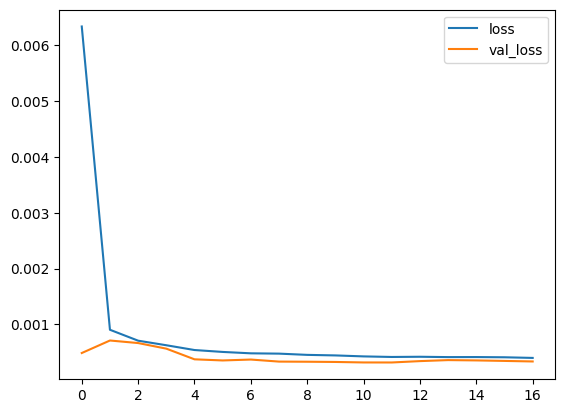

In [42]:
# Plot
pd.DataFrame(modelo_dsa.history.history).plot()

In [43]:
# Previsões
pred = modelo_dsa.predict(x_teste_final)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [44]:
# Calcula o score
score = np.sqrt(metrics.mean_squared_error(pred, y_teste_final))

In [45]:
print("Score (RMSE): {}".format(score))

Score (RMSE): 0.016347729300526484


## Previsões e Cálculo do Retorno

A linha de código abaixo está realizando a seguinte operação:

- Está prevendo valores para a entrada x_treino_final. Essa previsão retorna um array NumPy.

- Está criando um array NumPy de zeros com dimensões [lag,1]. A variável lag é geralmente um número inteiro que se refere a um período de atraso ou defasagem (por exemplo, se você está trabalhando com séries temporais e deseja considerar os 5 valores anteriores, o lag seria 5).

- Depois disso, está concatenando o array de zeros com as previsões do modelo ao longo do eixo 0 (ou seja, verticalmente). A razão para fazer isso é para ajustar o formato dos dados, porque você teve um deslocamento de lag ao criar os dados de entrada para o modelo, então agora precisa preencher esses primeiros pontos nos dados de saída.

In [46]:
y_pred_treino = np.concatenate((np.zeros([lag,1]), modelo_dsa.predict(x_treino_final)), axis = 0)

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Repetimos o mesmo com dados de validação e teste e então concatenamos.

In [47]:
y_pred_valid = np.concatenate((np.zeros([lag,1]), modelo_dsa.predict(x_valid_final)), axis = 0)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [48]:
y_pred_teste = np.concatenate((np.zeros([lag,1]), modelo_dsa.predict(x_teste_final)), axis = 0)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [49]:
# Concatena as previsões em treino, valid e teste como previsão final
df["prediction"] = np.concatenate((y_pred_treino, y_pred_valid, y_pred_teste), axis = 0)

In [50]:
df.tail()

Price,adj_close,close,high,low,open,volume,retorno,op,hi,lo,clo,vol,SMA 15,SMA 60,MSD 15,MSD 60,VWAP,RSI,prediction
date,,,,,,,,,,,,,,,,,,,
2023-12-22,370.375732,374.579987,375.179993,372.709991,373.679993,17091100,0.002784,372.559998,374.410004,370.040009,373.540009,17708000.0,371.795335,352.972669,0.010610,0.013211,371.030030,55.957485,-0.005726
2023-12-26,370.454834,374.660004,376.940002,373.500000,375.000000,12673100,0.000214,373.679993,375.179993,372.709991,374.579987,17091100.0,371.800000,353.988336,0.010216,0.013211,372.476155,59.580089,-0.005814
2023-12-27,369.871490,374.070007,375.059998,372.809998,373.690002,14905400,-0.001575,375.000000,376.940002,373.500000,374.660004,12673100.0,372.167999,354.970169,0.009410,0.013207,373.058044,59.897331,-0.005975
2023-12-28,371.067902,375.279999,376.459991,374.160004,375.369995,14327000,0.003235,373.690002,375.059998,372.809998,374.070007,14905400.0,372.271334,355.841336,0.009152,0.013046,373.430889,55.856718,-0.005623
2023-12-29,371.819366,376.040009,377.160004,373.480011,376.000000,18723000,0.002025,375.369995,376.459991,374.160004,375.279999,14327000.0,372.703335,356.872836,0.008715,0.012489,374.135981,62.365107,-0.005537


A linha de código abaixo está criando uma nova coluna chamada "dsa_estrategia" no DataFrame df. Os valores para essa coluna são calculados tomando a coluna "retorno" e multiplicando-a pelo sinal da previsão do dia anterior (obtido através de df["prediction"].shift(1)).

A função np.sign retorna -1 se o número for negativo, 0 se o número for zero e 1 se o número for positivo.

Ao usar shift(1), você está pegando os valores de "prediction" do dia anterior, porque shift(1) desloca os valores para baixo em uma linha.

Em outras palavras, a estratégia aqui é que se a previsão do dia anterior era positiva, então você assume uma posição longa (compra) e seu retorno é simplesmente o retorno do ativo. Se a previsão do dia anterior era negativa, então você assume uma posição curta (vende), e o seu retorno é o negativo do retorno do ativo (porque quando você vende um ativo a descoberto, você ganha dinheiro quando o preço cai).

É uma estratégia de negociação baseada nas previsões do dia anterior. Essa estratégia presume que você pode perfeitamente prever os valores do final do dia com base nas previsões do dia anterior.

Nota: A execução dessa estratégia seria um pouco mais complicada e incluiria custos de transação.

In [51]:
# Calcula a estratégia
df["dsa_estrategia"] = df["retorno"] * np.sign(df["prediction"].shift(1))

In [52]:
df.tail()

Price,adj_close,close,high,low,open,volume,retorno,op,hi,lo,clo,vol,SMA 15,SMA 60,MSD 15,MSD 60,VWAP,RSI,prediction,dsa_estrategia
date,,,,,,,,,,,,,,,,,,,,
2023-12-22,370.375732,374.579987,375.179993,372.709991,373.679993,17091100,0.002784,372.559998,374.410004,370.040009,373.540009,17708000.0,371.795335,352.972669,0.010610,0.013211,371.030030,55.957485,-0.005726,-0.002784
2023-12-26,370.454834,374.660004,376.940002,373.500000,375.000000,12673100,0.000214,373.679993,375.179993,372.709991,374.579987,17091100.0,371.800000,353.988336,0.010216,0.013211,372.476155,59.580089,-0.005814,-0.000214
2023-12-27,369.871490,374.070007,375.059998,372.809998,373.690002,14905400,-0.001575,375.000000,376.940002,373.500000,374.660004,12673100.0,372.167999,354.970169,0.009410,0.013207,373.058044,59.897331,-0.005975,0.001575
2023-12-28,371.067902,375.279999,376.459991,374.160004,375.369995,14327000,0.003235,373.690002,375.059998,372.809998,374.070007,14905400.0,372.271334,355.841336,0.009152,0.013046,373.430889,55.856718,-0.005623,-0.003235
2023-12-29,371.819366,376.040009,377.160004,373.480011,376.000000,18723000,0.002025,375.369995,376.459991,374.160004,375.279999,14327000.0,372.703335,356.872836,0.008715,0.012489,374.135981,62.365107,-0.005537,-0.002025


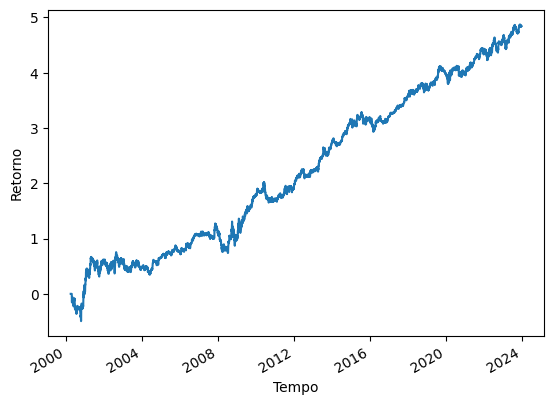

In [53]:
# Plot do acumulado
df["dsa_estrategia"].iloc[:].cumsum().plot()

# Adicionando rótulos aos eixos
plt.xlabel("Tempo")  
plt.ylabel("Retorno")  

# Exibindo o gráfico
plt.show()

Modelos de IA são aproximações. Use cada modelo sempre de forma cautelosa.

In [54]:
%watermark -a "Data Science Academy"

Author: Data Science Academy



In [55]:
#%watermark -v -m

In [56]:
#%watermark --iversions

# Fim